In [29]:
# imporing required libraries
import librosa, librosa.display
import matplotlib.pyplot as plt
import soundfile
import os, glob
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

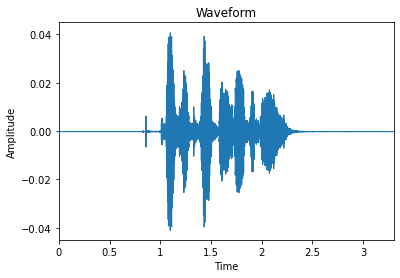

In [4]:
# Learning about different features

path = "./data.wav"
signal, sampleRate = librosa.load(path)

librosa.display.waveplot(signal, sr=sampleRate)
plt.title("Waveform")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

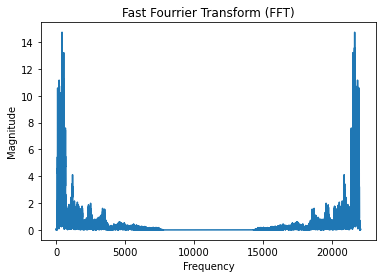

In [5]:
fft = np.fft.fft(signal)
magnitude = np.abs(fft)
frequency = np.linspace(0, sampleRate, len(magnitude))

plt.plot(frequency, magnitude)
plt.title("Fast Fourrier Transform (FFT)")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

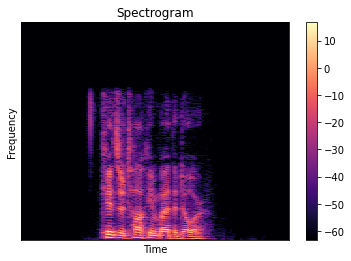

In [6]:
stft = librosa.core.stft(signal, hop_length=512)

spectrogram = np.abs(stft)
logSpectrogram = librosa.amplitude_to_db(spectrogram)

librosa.display.specshow(logSpectrogram, sr=sampleRate, hop_length=512)

plt.title("Spectrogram")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

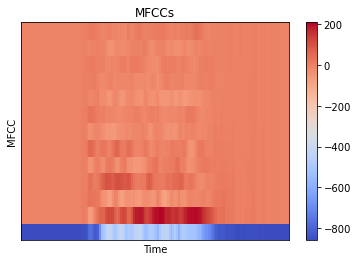

In [7]:
mfccs = librosa.feature.mfcc(signal, n_mfcc=13)

librosa.display.specshow(mfccs, sr=sampleRate, hop_length=512)

plt.title("MFCCs")
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar()
plt.show()

In [8]:
#extracting features (mfcc, chroma, mel) from a sound file
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
            
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            stft=np.abs(librosa.stft(X))
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
    return result

In [9]:
#emotions present in the RAVDESS dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

#emotions to observe
observed_emotions=['calm', 'happy', 'fearful', 'angry', 'disgust', 'surprised']

In [10]:
#loading data with observed_emotions and extracting features for each sound file
def load_data(test_size=0.2):
    x,y=[],[]
    for file in glob.glob("./data/Actor_*/*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [11]:
x_train,x_test,y_train,y_test=load_data()

In [12]:
print((x_train.shape[0], x_test.shape[0]))
print(f'Features extracted: {x_train.shape[1]}')

(921, 231)
Features extracted: 180


In [41]:
# building model
model=MLPClassifier(
    alpha=0.01,
    batch_size=256, 
    epsilon=1e-08,      
    hidden_layer_sizes=(600,), 
    learning_rate='adaptive', 
    max_iter=500
)

In [42]:
# training model
model.fit(x_train,y_train)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(600,),
              learning_rate='adaptive', max_iter=500)

In [43]:
# predicting for test data
y_pred=model.predict(x_test)

In [44]:
# evaluating accuracy
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 70.56%


array([[31,  1,  4,  3,  2,  4],
       [ 0, 32,  1,  1,  4,  0],
       [ 4,  4, 26,  1,  4,  3],
       [ 2,  0,  3, 31,  7,  0],
       [ 2,  0,  0,  2, 23,  6],
       [ 2,  0,  4,  0,  4, 20]])

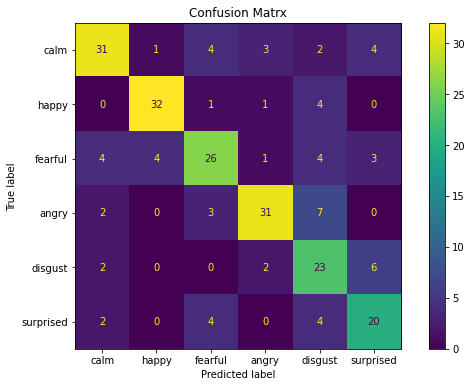

In [45]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Confusion Matrx')

disp =metrics.plot_confusion_matrix(model, x_test, y_test, display_labels= observed_emotions, ax = ax)
disp.confusion_matrix

In [46]:
print("F1", round(f1_score(y_test, y_pred, average='macro'),2))
print("Precision", round(precision_score(y_test, y_pred, average='macro'),2))
print("Recall", round(recall_score(y_test, y_pred, average='macro'),2))

F1 0.7
Precision 0.71
Recall 0.71
